In [ ]:
# utilities
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Dataset

In [ ]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/drive/MyDrive/NLP Project/Project_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

target         ids                          date      flag  \
218968       0  1976282444  Sat May 30 16:59:25 PDT 2009  NO_QUERY   
283131       0  1992821279  Mon Jun 01 09:22:34 PDT 2009  NO_QUERY   
998033       4  1836187292  Mon May 18 07:32:22 PDT 2009  NO_QUERY   
638610       0  2234502913  Thu Jun 18 23:10:40 PDT 2009  NO_QUERY   
690017       0  2251905209  Sat Jun 20 04:55:44 PDT 2009  NO_QUERY   

                   user                                               text  
218968   saharlestrange                                      I want hina!   
283131   dailyuncooking  @jo_jo_ba oooh I am so impressed my only attem...  
998033           JessRS  woohoo! celebrating e-mail to zero! my dear fr...  
638610      sideshowMel  @Silvialicious The gate was closed  It was a n...  
690017  NikkINightmarEx         my seatbelt is digging into my neck  ouchh

# EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


Text(0, 0.5, 'Count')

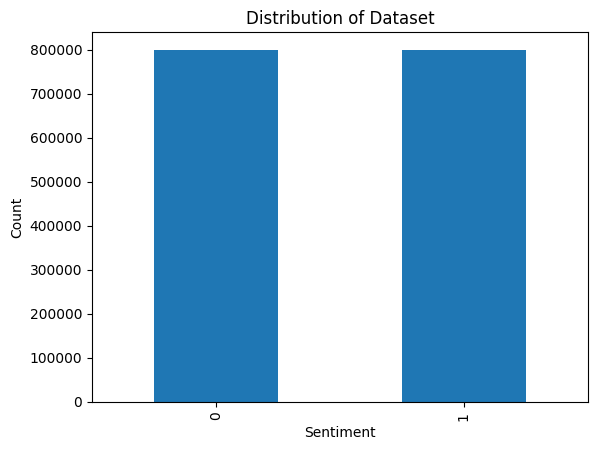

In [ ]:
x = data.target.value_counts()
x.plot(kind='bar')
plt.title('Distribution of Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [ ]:
positive_words_count = []
negative_words_count = []

for i in tqdm(range(len(data))):
    if data.iloc[i]['target'] == 1:
        positive_words_count.append(len(data.iloc[i]['text'].split()))
    elif data.iloc[i]['target'] == 0:
        negative_words_count.append(len(data.iloc[i]['text'].split()))

100%|██████████| 1600000/1600000 [07:25<00:00, 3589.73it/s]


In [ ]:
trace = go.Histogram(
    x = np.array(positive_words_count), 
    name = 'Positive'
)

trace2 = go.Histogram(
    x = np.array(negative_words_count),
    name = 'Negative'
)

layout = go.Layout(
    barmode='overlay',
    title="Distribution of Word Length for Each Class")

hist_data = [trace, trace2]
fig = go.Figure(data = hist_data, layout = layout)
fig.update_traces(opacity=0.4)
fig.show()

Text(0, 0.5, 'Count')

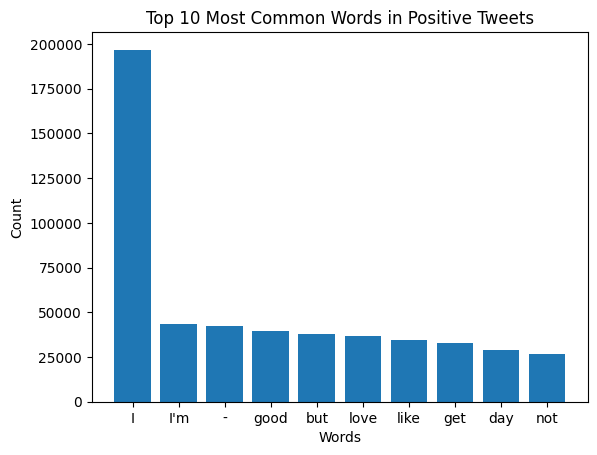

In [ ]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

corpus = []
word_positive = data_pos['text'].str.split()
listOfWordsPos = word_positive.values.tolist()
corpus=[word for i in listOfWordsPos for word in i]
counter = Counter(corpus)
mostCommonWords = counter.most_common(100)
xPos, yPos = [], []
for word, count in mostCommonWords[:40]:
  if word not in stopwordlist:
    xPos.append(word)
    yPos.append(count)

plt.bar(xPos, yPos)
plt.title("Top 10 Most Common Words in Positive Tweets")
plt.xlabel("Words")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

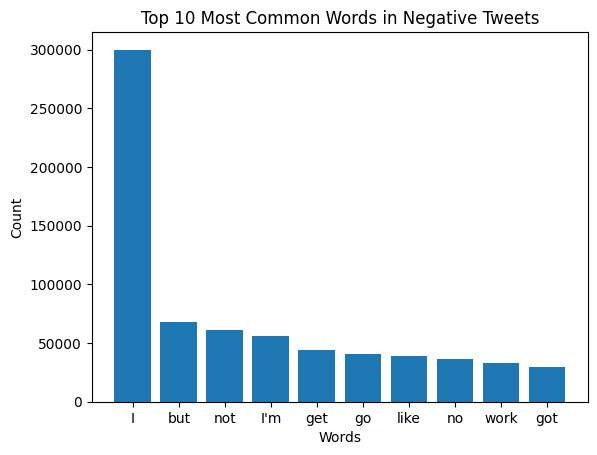

In [ ]:
corpus = []
word_negative = data_neg['text'].str.split()
listOfWordsNeg = word_negative.values.tolist()
corpus=[word for i in listOfWordsNeg for word in i]
counter = Counter(corpus)
mostCommonWords = counter.most_common(100)
xNeg, yNeg = [], []
for word, count in mostCommonWords[:38]:
  if word not in stopwordlist:
    xNeg.append(word)
    yNeg.append(count)

plt.bar(xNeg, yNeg)
plt.title("Top 10 Most Common Words in Negative Tweets")
plt.xlabel("Words")
plt.ylabel("Count")

# Text Preprocessing

In [ ]:
data=df[['text','target']]

In [ ]:
data['target'] = data['target'].replace(4,1)

<ipython-input-5-54c9eb4fa536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [ ]:
data['target'].unique()

array([0, 1])

In [ ]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [ ]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
dataset = pd.concat([data_pos, data_neg])

In [ ]:
dataset = data

In [ ]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

<ipython-input-8-cfdfd7510b56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']=dataset['text'].str.lower()


1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, dtype: object

In [ ]:
dataset.shape

(1600000, 2)

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()


<ipython-input-11-c1f31e612afa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))


0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass no, it's not behaving all. i'...
Name: text, dtype: object

In [ ]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

<ipython-input-12-eef4fe1f8188>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

<ipython-input-13-2587a2d701f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

<ipython-input-14-585aef627fe0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

<ipython-input-15-dccce35b8388>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))


1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
dataset['text'] = dataset['text'].apply(word_tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [ ]:
dataset.tail()

text  target
1599995                woke up no school best feeling ever       1
1599996  thewdbcom  cool hear old walt interviews â« h...       1
1599997                    ready mojo makeover ask details       1
1599998  happy th birthday boo alll time tupac amaru sh...       1
1599999  happy charitytuesday thenspcc sparkscharity sp...       1

In [ ]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

<ipython-input-18-94e712156fbb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))


0    switchfoot httptwitpiccomzl  a s bummer should...
1    upset cant update facebook texting it might cr...
2    kenichan dived many times ball managed save  r...
3                     whole body feels itchy like fire
4    nationwideclass no its not behaving all im mad...
Name: text, dtype: object

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

<ipython-input-20-38fe06806eb8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))


0    switchfoot httptwitpiccomzl  a s bummer should...
1    upset cant update facebook texting it might cr...
2    kenichan dived many times ball managed save  r...
3                     whole body feels itchy like fire
4    nationwideclass no its not behaving all im mad...
Name: text, dtype: object

# PreProcessing Done!!!!!!!!!!!!!!!!!

# Wordcloud Visualizations

In [ ]:
X=dataset.text
y=dataset.target

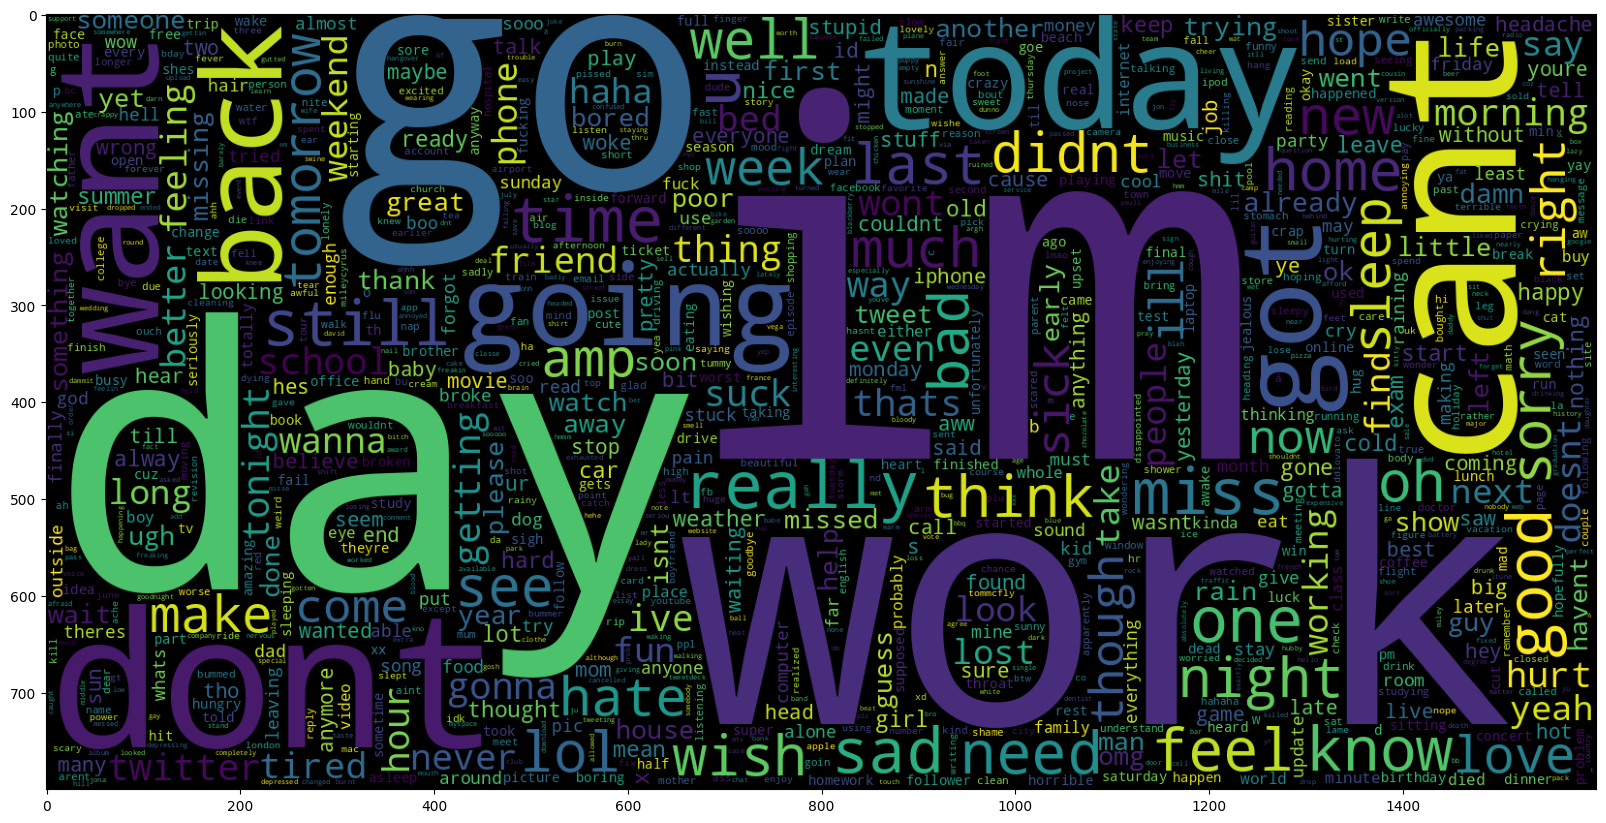

In [ ]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

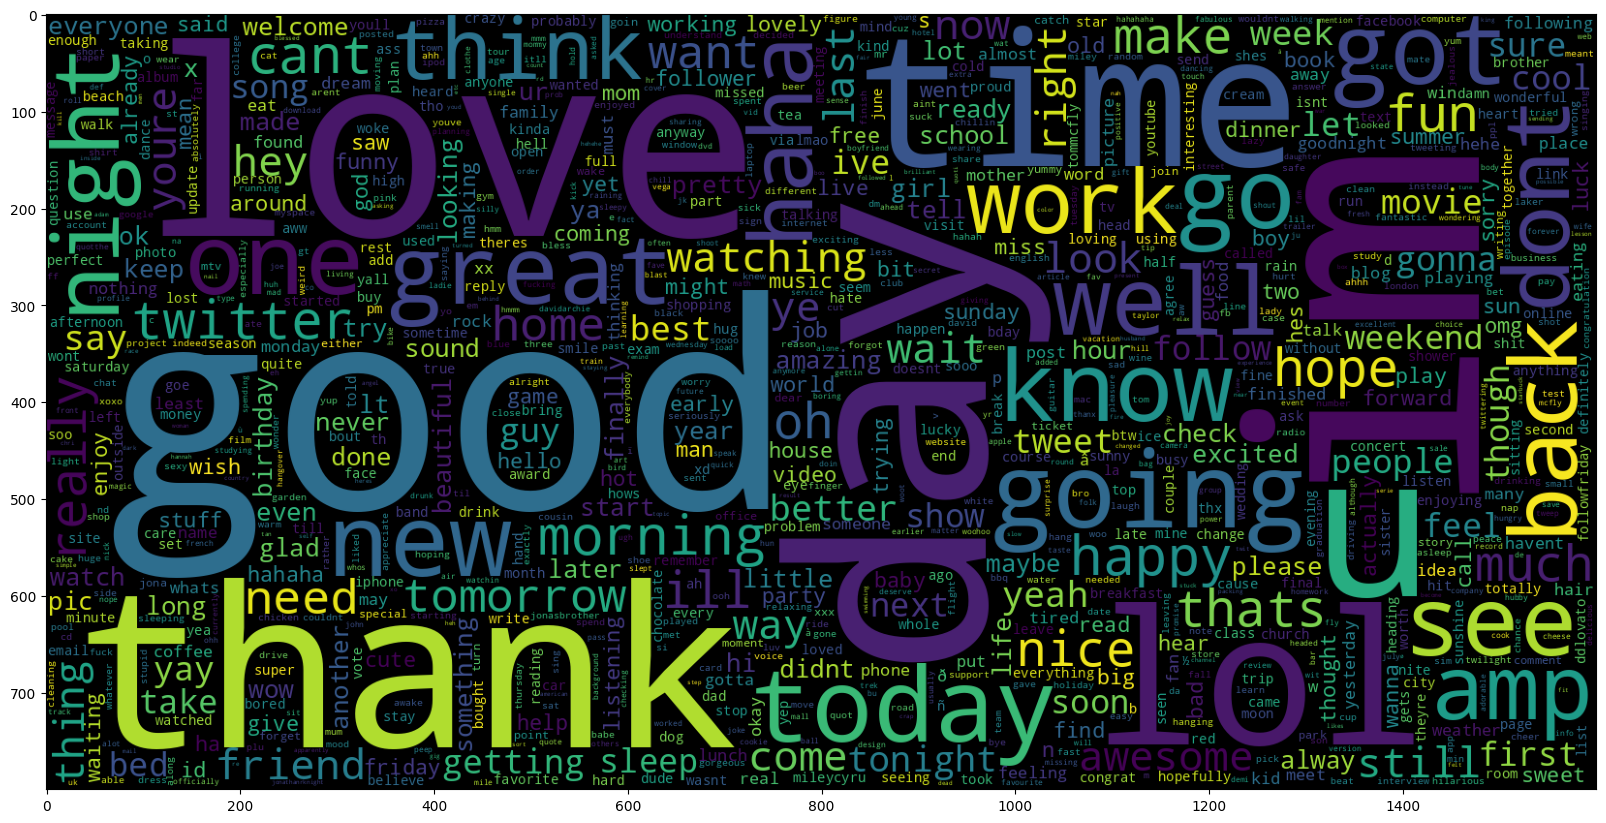

In [ ]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

# Supervised Sentiment Analysis

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
X.shape

(1600000,)

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [ ]:
X_train.shape

(1520000,)

In [ ]:
test = X_test

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
X_train

<1520000x500000 sparse matrix of type '<class 'numpy.float64'>'
	with 16922290 stored elements in Compressed Sparse Row format>

In [ ]:
def model_Evaluate(model):


  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Naive Bayes

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     40100
           1       0.78      0.81      0.80     39900

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



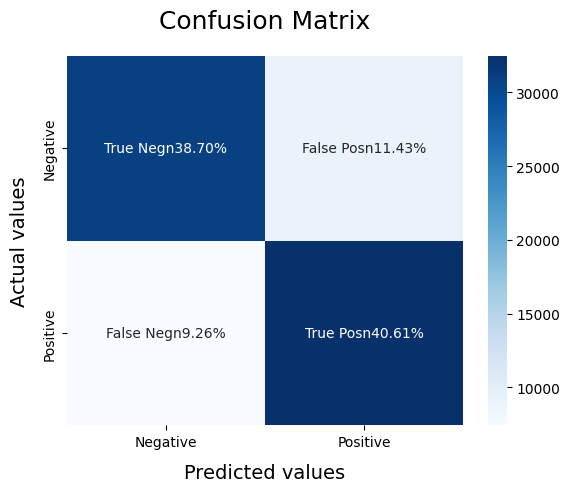

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

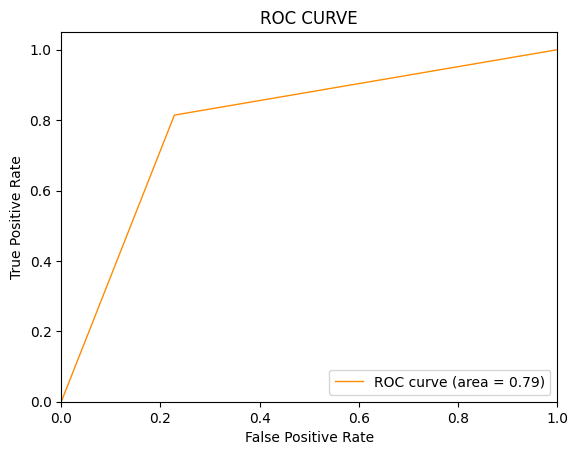

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
test[1000:1005]

196677     keef urm yes backed everything up sadly didnt ...
954721     ratpack week american idol kick awesome really...
1360115    owthese headphones kinda hurt least keep surro...
1465527                         cmgangrel aaah success knife
1404964    yeaah finally got cool peeps tweet with love m...
Name: text, dtype: object

In [ ]:
BNBmodel.predict(vectoriser.transform(test[1000:1005]))

array([0, 1, 0, 1, 1])

## SVM

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.79      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



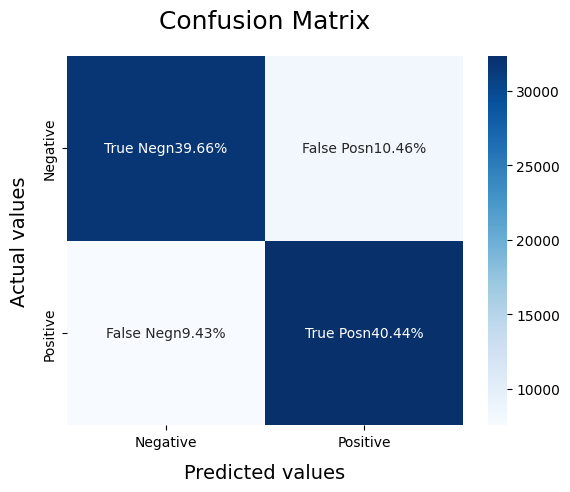

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

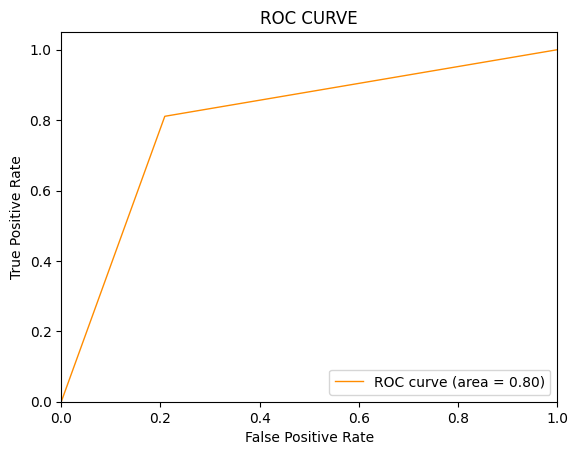

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
test[1000:1005]

196677     keef urm yes backed everything up sadly didnt ...
954721     ratpack week american idol kick awesome really...
1360115    owthese headphones kinda hurt least keep surro...
1465527                         cmgangrel aaah success knife
1404964    yeaah finally got cool peeps tweet with love m...
Name: text, dtype: object

In [ ]:
SVCmodel.predict(vectoriser.transform(test[1000:1005]))

array([0, 1, 0, 1, 1])

## Logistic Regression

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     40100
           1       0.81      0.83      0.82     39900

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



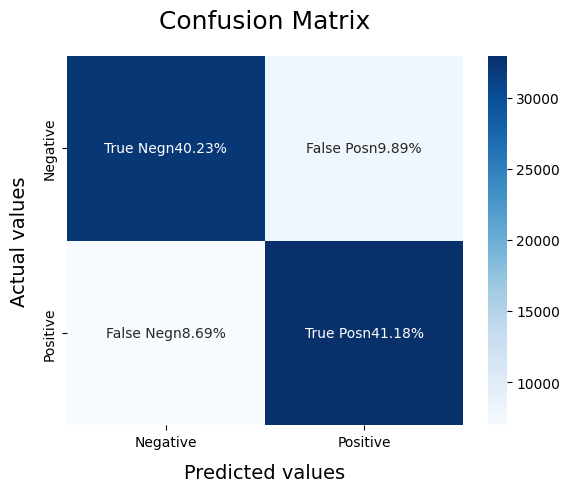

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

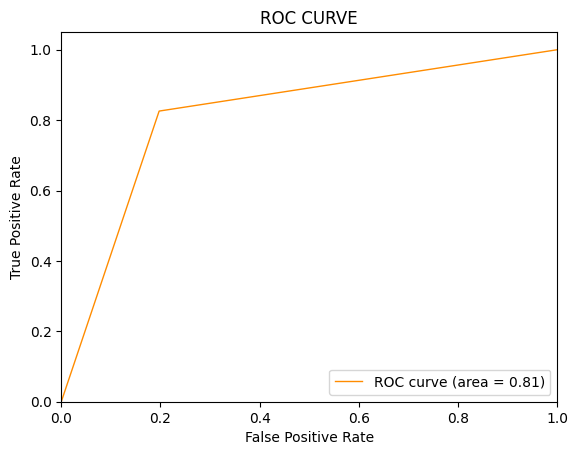

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
test[1000:1005]

196677     keef urm yes backed everything up sadly didnt ...
954721     ratpack week american idol kick awesome really...
1360115    owthese headphones kinda hurt least keep surro...
1465527                         cmgangrel aaah success knife
1404964    yeaah finally got cool peeps tweet with love m...
Name: text, dtype: object

In [ ]:
LRmodel.predict(vectoriser.transform(test[1000:1005]))

array([0, 1, 0, 1, 1])